# Benchmarking Foundation Models Notebook 

Authors:
- Helio Halperin (heliohalperin@gmail.com)
- Simon Lee (simonlee711@g.ucla.edu)

2024

In [3]:
# !pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade
# !pip install git+https://github.com/huggingface/transformers.git

# !pip install transformers datasets[s3] sagemaker --upgrade
# !pip install scikit-learn
# !pip install accelerate==0.21.0
# !pip install fastprogress
# !pip install lightgbm

In [4]:
!pwd

/root/simonlee/src/antibiotics-fm-benchmark


In [5]:
# Basic imports
import numpy as np
import pandas as pd
import json
import pickle
import torch
import torch.nn as nn

# AWS imports
import boto3
from sagemaker import get_execution_role

# I/O imports
from io import StringIO

# Progress and visualization imports
from tqdm.auto import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Sklearn metrics imports
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# Transformers imports
from transformers import (AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, 
    DataCollatorWithPadding, TrainingArguments, Trainer, TextClassificationPipeline, 
    AdamW, get_scheduler
)
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets, load_metric

# PyTorch data handling
from torch.utils.data import DataLoader

from scripts.train_test_split import custom_train_test_split
from scripts.encoder import encode_texts
from scripts.train_test import evaluate_antibiotics_with_confidence_intervals, print_results
from scripts.plot import plot_roc_curves, plot_auprc_curves, calculate_confidence_interval

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# read in data

In [12]:
data = pd.read_csv("./data/antibiotics_labels.csv")
display(data)

,subject_id,stay_id,hadm_id,arrival,triage,medrecon,vitals,codes,pyxis,patient_paragraph,...,DAPTOMYCIN,ERYTHROMYCIN,GENTAMICIN,LEVOFLOXACIN,NITROFURANTOIN,OXACILLIN,RIFAMPIN,TETRACYCLINE,TRIMETHOPRIM/SULFA,VANCOMYCIN
0,10002443,33425241,21329021,"Patient 10002443, a 53 year old white male, ar...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2183-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10002443, a 53 year old white male, ar...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,10005858,39055405,29352282,"Patient 10005858, a 62 year old white female, ...","At triage: temperature was 102.7, pulse was 93...",The patient was previously taking the followin...,The patient had the following vitals: At 2172-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10005858, a 62 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,10014078,38676365,25809882,"Patient 10014078, a 60 year old unable to obta...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014078, a 60 year old unable to obta...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,19989126,35420737,22853928,"Patient 19989126, a 45 year old asian female, ...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19989126, a 45 year old asian female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5978,19990821,35896332,27777812,"Patient 19990821, a 70 year old unknown male, ...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient has no diagnostic codes recorded.,The patient received the following medications...,"Patient 19990821, a 70 year old unknown male, ...",...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
5979,19991805,34001852,23646288,"Patient 19991805, a 80 year old white female, ...","At triage: temperature was 97.9, pulse was 67....",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19991805, a 80 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5980,19994772,37554330,29199248,"Patient 19994772, a 54 year old white female, ...","At triage: temperature was 96.7, pulse was 79....",The patient was previously taking the followin...,The patient had the following vitals: At 2181-...,The patient received the following diagnostic ...

In [14]:
# List of antibiotics we are interested in
############################################
## We may or may not study NITROFURANTOIN ## 
## Because only 6% of patients were       ##
## prescribed it                          ##
############################################

antibiotics = ['CLINDAMYCIN', 'ERYTHROMYCIN', 'GENTAMICIN', 'LEVOFLOXACIN', 
               'OXACILLIN', 'TETRACYCLINE', 'TRIMETHOPRIM/SULFA', 
               'VANCOMYCIN']

In [15]:
# # Split data into 80% and 20$ cuts
train_val, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

print('TRAIN:', len(train), 'TEST:', len(test))

TRAIN: 4844 TEST: 599


# DistilBERT (baseline)

In [ ]:
# Generate Embeddings for each set of data
## We can plug in any models found on the huggingface platform
##
X_train = encode_texts('distilbert-base-uncased', train['patient_paragraph'].tolist())
X_test = encode_texts('distilbert-base-uncased', test['patient_paragraph'].tolist())

In [ ]:
## Evaluate 
distilbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)

In [ ]:
print_results(distilbert_results)

# Biomegatron

In [ ]:
X_train = encode_texts('EMBO/BioMegatron345mUncased', train['patient_paragraph'].tolist())
X_test = encode_texts('EMBO/BioMegatron345mUncased', test['patient_paragraph'].tolist())
## Make sure to rename
biomegatron_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(biomegatron_results)

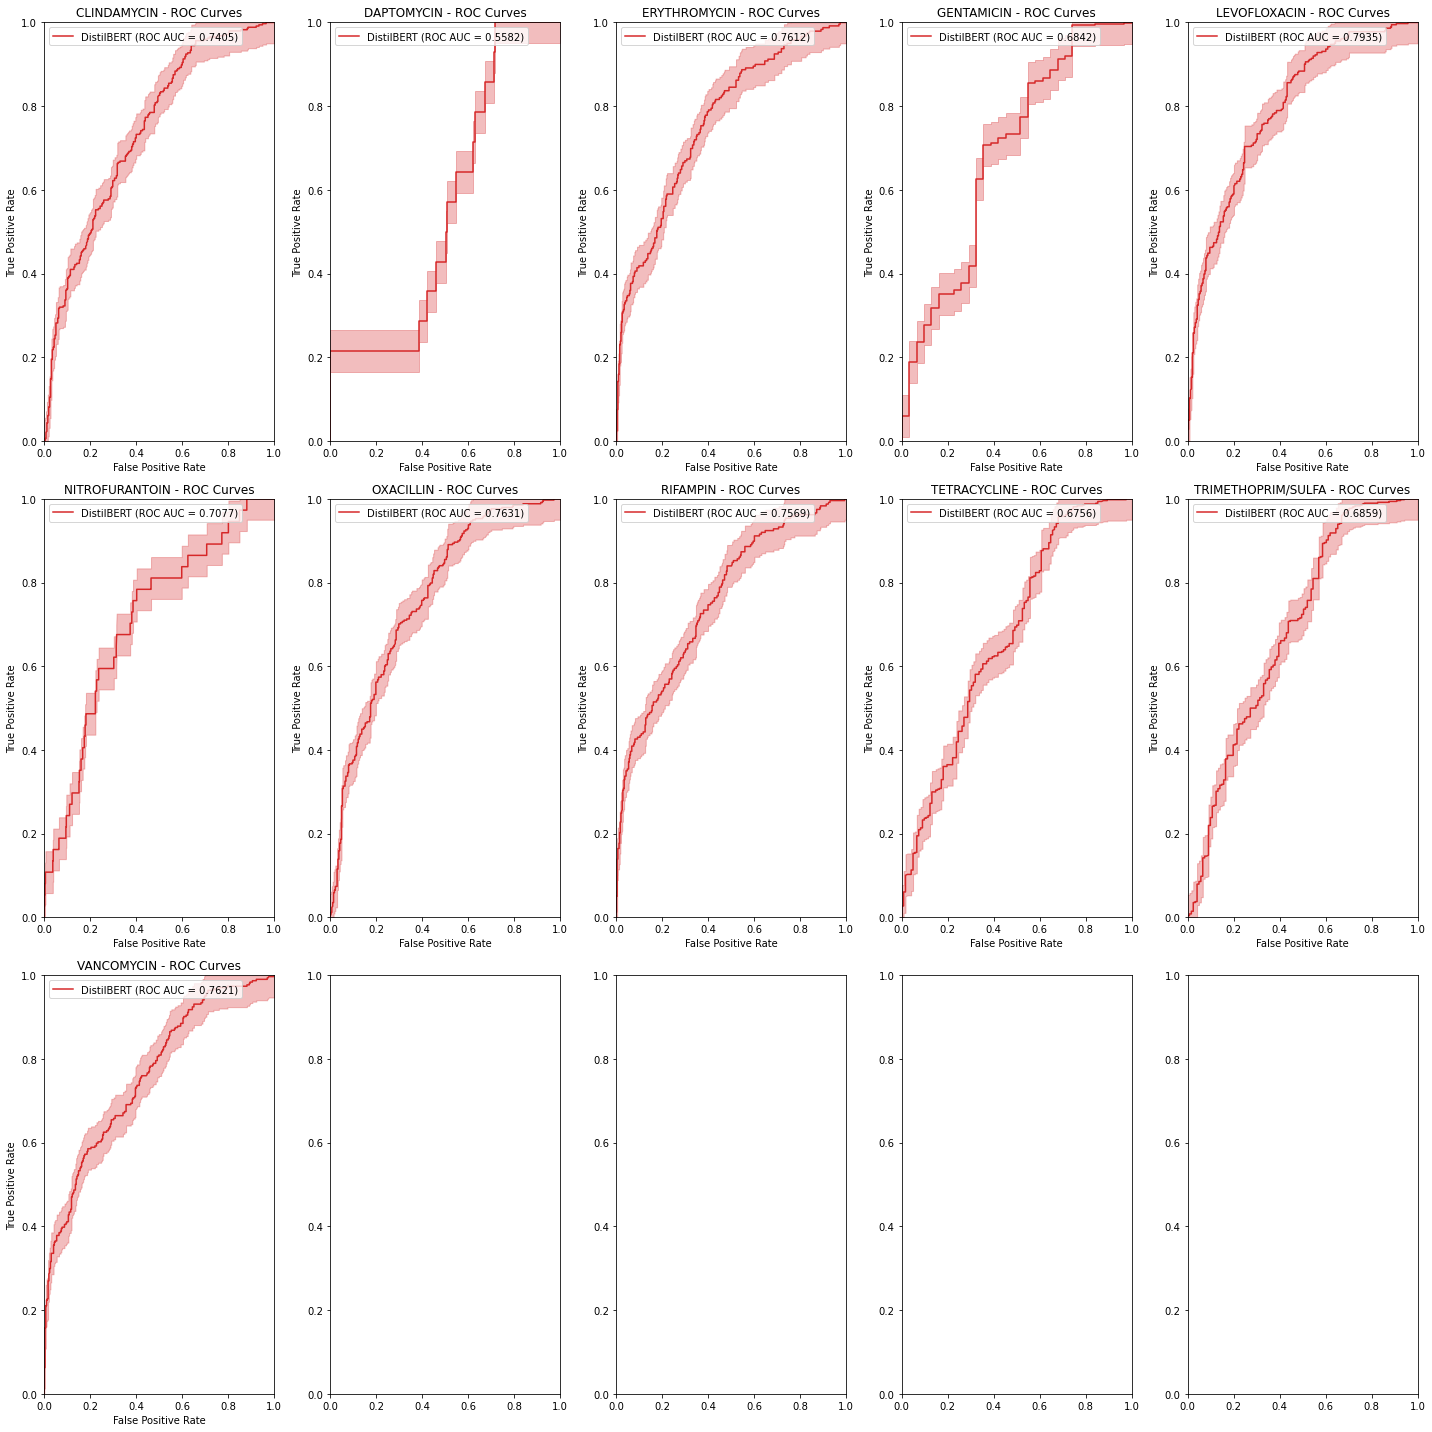

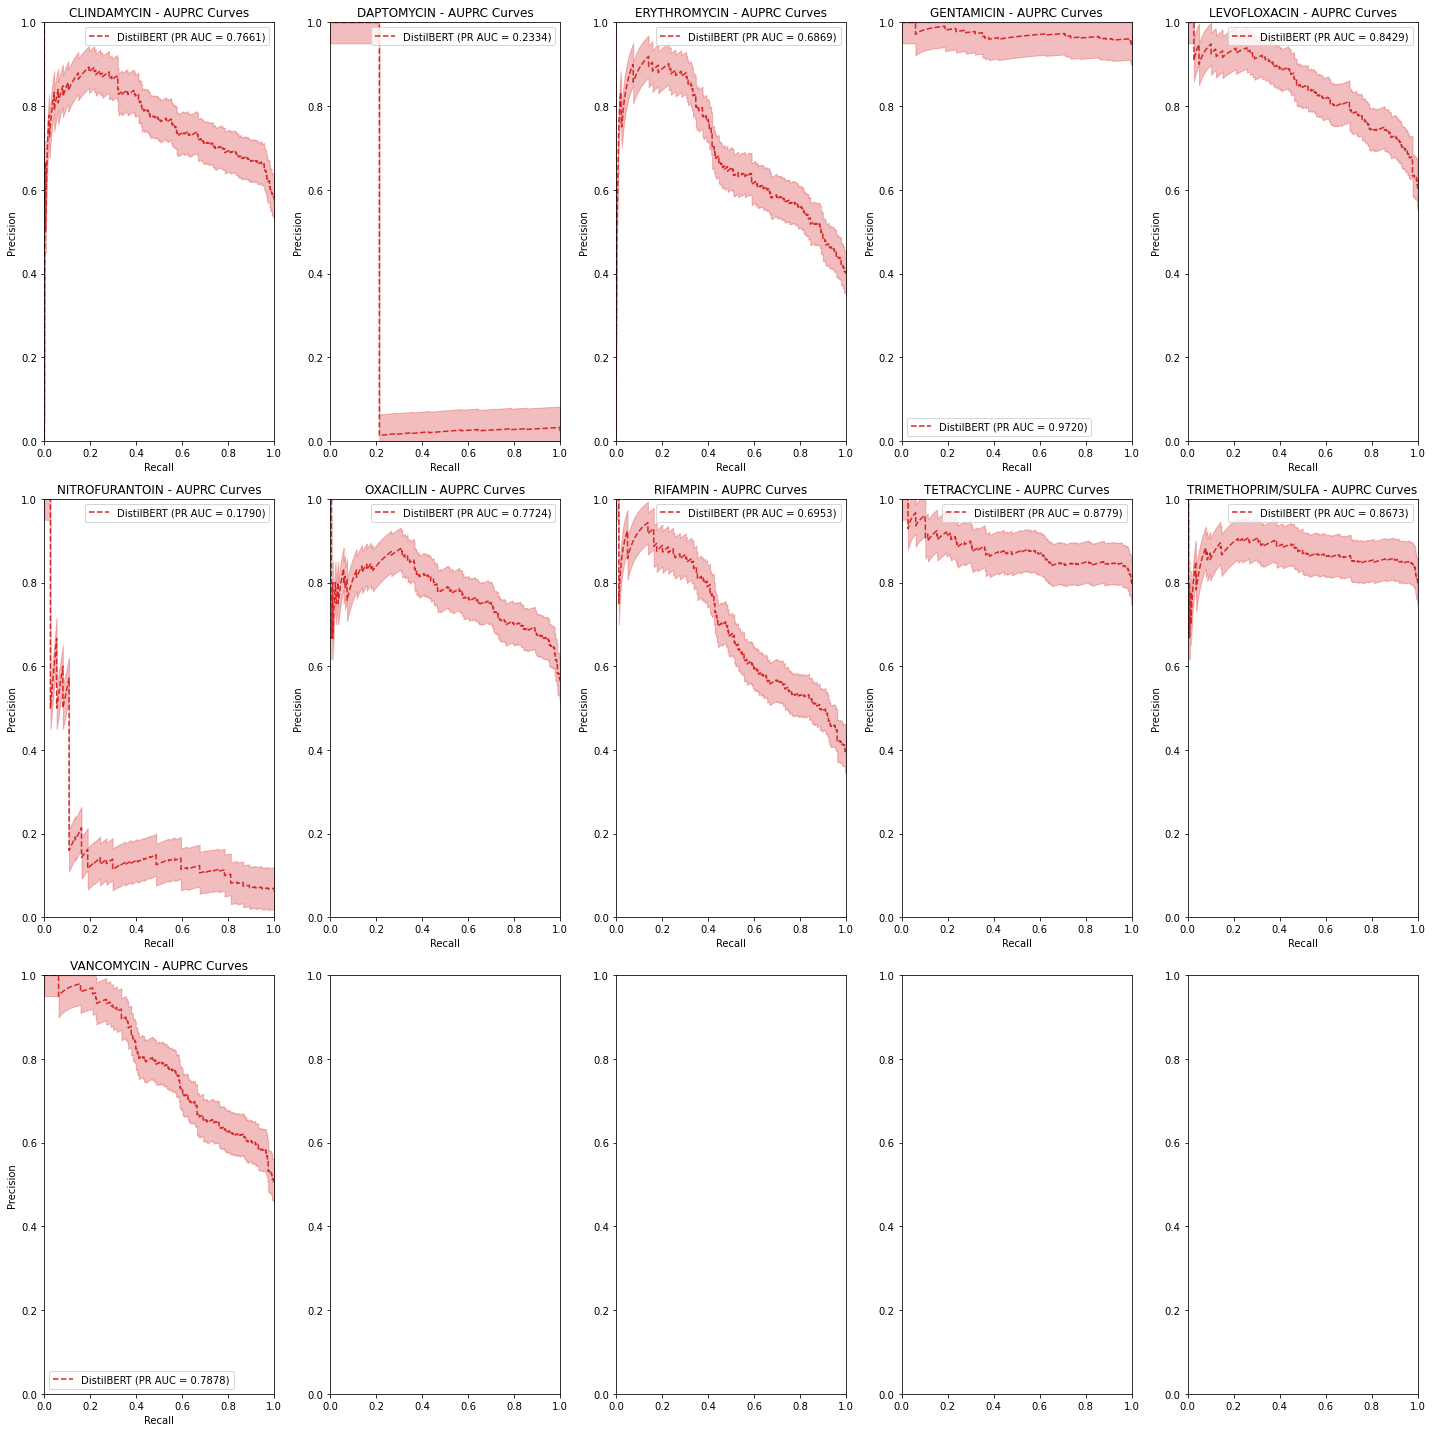

In [21]:
model_colors = {
    "LGBM": '#1f77b4',
    "EHR-shot": '#ff7f0e',
    "Word2Vec": '#2ca02c',
    "DistilBERT": '#d62728',
    "BioMegatron": '#9467bd'
}

# Dictionaries with their corresponding model names
dictionaries = [
    (distilbert_results, "DistilBERT"),
    (biomegatron_results, "BioMegatron" 
]
plot_roc_curves(antibiotics, dictionaries, model_colors)
plot_auprc_curves(antibiotics, dictionaries, model_colors)